<a href="https://colab.research.google.com/github/Inbal-Schekler/UNET-flocks-detection/blob/main/3_prev_image_unet_birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## For loading my model
## Need to restart after it

! pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 7.8 MB/s 
     |████████████████████████████████| 15.7 MB 75.5 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.5.3 which is incompatible.
lucid 0.3.10 requires numpy<=1.19, but you have numpy 1.21.6 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, bu

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

MessageError: ignored

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   137k      0 --:--:-- --:--:-- --:--:--  137k
OK
W: GPG error: https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease: The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
E: The repository 'https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease' is no longer signed.
gcsfuse is already the newest version (0.41.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 238 not upgraded.


In [ ]:
!mkdir colab_direcoty

!gcsfuse --implicit-dirs radar_data_israel colab_direcoty

mkdir: cannot create directory ‘colab_direcoty’: File exists
2022/08/02 08:49:50.469972 Start gcsfuse/0.41.4 (Go version go1.17.6) for app "" using mount point: /content/colab_direcoty
2022/08/02 08:49:50.486296 Opening GCS connection...
2022/08/02 08:49:50.622314 Mounting file system "radar_data_israel"...
2022/08/02 08:49:50.622661 File system has been successfully mounted.


In [ ]:
!ls colab_direcoty

Meron_crop  nothing    Ramon_run   trainHistoryDict_bucket  winter
models	    passerine  Spring_run  unet_bucket_17	    WRADH


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
from keras import metrics
from keras import regularizers
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from datetime import datetime
import re
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

Using TensorFlow backend.


In [ ]:
##Meron

list_tiff_meron_train = glob.glob('colab_direcoty/Meron_crop/dates/train/*/*.tiff')
print("length of image list_meron",len(list_tiff_meron_train))

list_tiff_meron_order= sorted(list_tiff_meron_train,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))


## Ramon
list_tiff_ramon_train =glob.glob('colab_direcoty/Ramon_run/dates/train/*/*.tiff')
print("length of image list_ramon",len(list_tiff_ramon_train))

list_tiff_ramon_order= sorted(list_tiff_ramon_train,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))

## Full list tiff
## I sorted by time both lists seperatly and than concatenate them
train_files=list_tiff_meron_order + list_tiff_ramon_order

print("length of full image list train",len(train_files))



length of image list_meron 1733
length of image list_ramon 1293
length of full image list train 3026


In [ ]:
list_tiff_meron_test = glob.glob('colab_direcoty/Meron_crop/dates/test/*/*.tiff')
print("length of image list_meron",len(list_tiff_meron_test))

list_tiff_meron_test_order= sorted(list_tiff_meron_test,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))



## Ramon
list_tiff_ramon_test =glob.glob('colab_direcoty/Ramon_run/dates/test/*/*.tiff')
print("length of image list_ramon",len(list_tiff_ramon_test))

list_tiff_ramon_test_order= sorted(list_tiff_ramon_test,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))

## Full list tiff

test_files=list_tiff_meron_test_order + list_tiff_ramon_test_order

print("length of full image list test",len(test_files))


length of image list_meron 230
length of image list_ramon 190
length of full image list test 420


In [ ]:
list_mask_meron_train= glob.glob('colab_direcoty/Meron_crop/dates/train/*/*.png')
print("length of image list",len(list_mask_meron_train))

list_mask_meron_train_order=sorted(list_mask_meron_train, key=lambda file: (datetime.strptime(file.split('/')[-2].replace('.', ''), '%d%m%Y'), int(os.path.basename(file).split('-')[0])))

list_mask_ramon_train= glob.glob('colab_direcoty/Ramon_run/dates/train/*/*.png')
print("length of image list",len(list_mask_ramon_train))

list_mask_ramon_train_order= sorted(list_mask_ramon_train, key=lambda file: (datetime.strptime(file.split('/')[-2].replace('.', ''), '%d%m%Y'), int(os.path.basename(file).split('-')[0])))

list_mask_train=list_mask_meron_train_order + list_mask_ramon_train_order
print("length of full mask train list",len(list_mask_train))



length of image list 1733
length of image list 1293
length of full mask train list 3026


In [ ]:
list_mask_meron_test= glob.glob('colab_direcoty/Meron_crop/dates/test/*/*.png')
print("length of image list",len(list_mask_meron_test))

list_mask_meron_test_order=sorted(list_mask_meron_test, key=lambda file: (datetime.strptime(file.split('/')[-2].replace('.', ''), '%d%m%Y'), int(os.path.basename(file).split('-')[0])))


list_mask_ramon_test= glob.glob('colab_direcoty/Ramon_run/dates/test/*/*.png')
print("length of image list",len(list_mask_ramon_test))

list_mask_ramon_test_order=sorted(list_mask_ramon_test, key=lambda file: (datetime.strptime(file.split('/')[-2].replace('.', ''), '%d%m%Y'), int(os.path.basename(file).split('-')[0])))


list_mask_test=list_mask_meron_test_order + list_mask_ramon_test_order
print("length of full mask test",len(list_mask_test))

length of image list 230
length of image list 190
length of full mask test 420


In [ ]:
##Meron

list_tiff_meron_winter_train = glob.glob('colab_direcoty/winter/meron/train/*/*/*/*.tiff')
print("length of image list_meron train winter",len(list_tiff_meron_winter_train))


## Ramon
list_tiff_ramon_winter_train =glob.glob('colab_direcoty/winter/ramon/train/*/*/*/*.tiff')
print("length of image list_ramon train winter",len(list_tiff_ramon_winter_train))

## Full list tiff winter train

train_files_winter=list_tiff_meron_winter_train + list_tiff_ramon_winter_train

print("length of full image list train winter",len(train_files_winter))

length of image list_meron train winter 188
length of image list_ramon train winter 45
length of full image list train winter 233


For the winter - train



In [ ]:
##Meron

list_tiff_meron_winter_train = glob.glob('colab_direcoty/winter/meron/train/*/*/*/*.tiff')
print("length of image list_meron train winter",len(list_tiff_meron_winter_train))

list_tiff_meron_winter_train_order = sorted(list_tiff_meron_winter_train,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))


## Ramon
list_tiff_ramon_winter_train =glob.glob('colab_direcoty/winter/ramon/train/*/*/*/*.tiff')
print("length of image list_ramon train winter",len(list_tiff_ramon_winter_train))

list_tiff_ramon_winter_train_order = sorted(list_tiff_ramon_winter_train,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))


## Full list tiff winter train

train_files_winter=list_tiff_meron_winter_train_order + list_tiff_ramon_winter_train_order

print("length of full image list train winter",len(train_files_winter))


length of image list_meron train winter 188
length of image list_ramon train winter 45
length of full image list train winter 233


Winter test

In [ ]:
##Meron

list_tiff_meron_winter_test = glob.glob('colab_direcoty/winter/meron/test/*/*/*/*.tiff')
print("length of image list_meron test winter",len(list_tiff_meron_winter_test))

list_tiff_meron_winter_test_order = sorted(list_tiff_meron_winter_test,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))


## Ramon
list_tiff_ramon_winter_test =glob.glob('colab_direcoty/winter/ramon/test/*/*/*/*.tiff')
print("length of image list_ramon test winter",len(list_tiff_ramon_winter_test))

list_tiff_ramon_winter_test_order = sorted(list_tiff_ramon_winter_test,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))


## Full list tiff winter test

test_files_winter=list_tiff_meron_winter_test_order + list_tiff_ramon_winter_test_order

print("length of full image list test winter",len(test_files_winter))



length of image list_meron test winter 121
length of image list_ramon test winter 53
length of full image list test winter 174


Passerine train


In [ ]:
##Meron

list_tiff_meron_passerine_train = glob.glob('colab_direcoty/passerine/meron/train/*/*/*/*.tiff')
print("length of image list_meron train passerine",len(list_tiff_meron_passerine_train))

list_tiff_meron_passerine_train_order = sorted(list_tiff_meron_passerine_train,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))


## Ramon
list_tiff_ramon_passerine_train =glob.glob('colab_direcoty/passerine/ramon/train/*/*/*/*.tiff')
print("length of image list_ramon train passerine",len(list_tiff_ramon_passerine_train))

list_tiff_ramon_passerine_train_order = sorted(list_tiff_ramon_passerine_train,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))



## Full list tiff passerine train

train_files_passerine=list_tiff_meron_passerine_train_order + list_tiff_ramon_passerine_train_order

print("length of full image list train passerine",len(train_files_passerine))


length of image list_meron train passerine 308
length of image list_ramon train passerine 304
length of full image list train passerine 612


Passerine test

In [ ]:
##Meron

list_tiff_meron_passerine_test = glob.glob('colab_direcoty/passerine/meron/test/*/*/*/*.tiff')
print("length of image list_meron test passerine",len(list_tiff_meron_passerine_test))

list_tiff_meron_passerine_test_order = sorted(list_tiff_meron_passerine_test,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))



## Ramon
list_tiff_ramon_passerine_test =glob.glob('colab_direcoty/passerine/ramon/test/*/*/*/*.tiff')
print("length of image list_ramon test passerine",len(list_tiff_ramon_passerine_test))

list_tiff_ramon_passerine_test_order = sorted(list_tiff_ramon_passerine_test,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))


## Full list tiff passerine test

test_files_passerine=list_tiff_meron_passerine_test_order + list_tiff_ramon_passerine_test_order

print("length of full image list test passerine",len(test_files_passerine))



length of image list_meron test passerine 155
length of image list_ramon test passerine 117
length of full image list test passerine 272


Adding days with nothing (from June) train

In [ ]:
##Meron

list_tiff_meron_nothing_train = glob.glob('colab_direcoty/nothing/meron/train/2019/*/*/*.tiff')
print("length of image list_meron train nothing",len(list_tiff_meron_nothing_train))

list_tiff_meron_nothing_train_order = sorted(list_tiff_meron_nothing_train,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))


## Ramon
list_tiff_ramon_nothing_train =glob.glob('colab_direcoty/nothing/ramon/train/*/*/*/*.tiff')
print("length of image list_ramon train nothing",len(list_tiff_ramon_nothing_train))

list_tiff_ramon_nothing_train_order = sorted(list_tiff_ramon_nothing_train,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))


## Full list tiff nothing train 

train_files_nothing=list_tiff_meron_nothing_train_order + list_tiff_ramon_nothing_train_order

print("length of full image list train nothing",len(train_files_nothing))


length of image list_meron train nothing 1535
length of image list_ramon train nothing 733
length of full image list train nothing 2268


Adding days eith nothing test

In [ ]:
##Meron

list_tiff_meron_nothing_test = glob.glob('colab_direcoty/nothing/meron/test/*/*/*/*.tiff')
print("length of image list_meron test nothing",len(list_tiff_meron_nothing_test))

list_tiff_meron_nothing_test_order = sorted(list_tiff_meron_nothing_test,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))



## Ramon
list_tiff_ramon_nothing_test =glob.glob('colab_direcoty/nothing/ramon/test/*/*/*/*.tiff')
print("length of image list_ramon test nothing",len(list_tiff_ramon_nothing_test))

list_tiff_ramon_nothing_test_order = sorted(list_tiff_ramon_nothing_test,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))


## Full list tiff nothing train 

test_files_nothing=list_tiff_meron_nothing_test_order + list_tiff_ramon_nothing_test_order

print("length of full image list test nothing",len(test_files_nothing))


length of image list_meron test nothing 246
length of image list_ramon test nothing 258
length of full image list test nothing 504


Adding the winter, passerine and nothing to the lists

In [ ]:
train_files=train_files + train_files_winter+train_files_passerine + train_files_nothing

print("length of train files",len(train_files))

test_files = test_files +test_files_winter + test_files_passerine + test_files_nothing


print("length of test files",len(test_files))



length of train files 6139
length of test files 1370


When using Drive

In [ ]:
"""
list_tiff_meron_train = glob.glob('/content/drive/My Drive/tag_work/pic_biorad/label_studio/Meron_crop/dates/train/*/*.tiff')
print("length of image list_meron",len(list_tiff_meron_train))

## Ramon
list_tiff_ramon_train =glob.glob('/content/drive/My Drive/tag_work/pic_biorad/label_studio/Ramon_run/dates/train/*/*.tiff')
print("length of image list_ramon",len(list_tiff_ramon_train))

## Full list tiff

train_files=list_tiff_meron_train + list_tiff_ramon_train

print("length of full image list train",len(train_files))
"""


length of image list_meron 1870
length of image list_ramon 1293
length of full image list train 3163


In [ ]:
"""
list_tiff_meron_test = glob.glob('/content/drive/My Drive/tag_work/pic_biorad/label_studio/Meron_crop/dates/test/*/*.tiff')
print("length of image list_meron",len(list_tiff_meron_test))

## Ramon
list_tiff_ramon_test =glob.glob('/content/drive/My Drive/tag_work/pic_biorad/label_studio/Ramon_run/dates/test/*/*.tiff')
print("length of image list_ramon",len(list_tiff_ramon_test))

## Full list tiff

test_files=list_tiff_meron_test + list_tiff_ramon_test

print("length of full image list train",len(test_files))
"""


length of image list_meron 230
length of image list_ramon 190
length of full image list train 420


In [ ]:
"""
list_mask_meron_train= glob.glob('/content/drive/My Drive/tag_work/pic_biorad/label_studio/Meron_crop/dates/train/*/*.png')
print("length of image list",len(list_mask_meron_train))

list_mask_ramon_train= glob.glob('/content/drive/My Drive/tag_work/pic_biorad/label_studio/Ramon_run/dates/train/*/*.png')
print("length of image list",len(list_mask_ramon_train))

list_mask_train=list_mask_meron_train + list_mask_ramon_train
print("length of full image list",len(list_mask_train))
"""

length of image list 1870
length of image list 1293
length of full image list 3163


In [ ]:
"""
list_mask_meron_test= glob.glob('/content/drive/My Drive/tag_work/pic_biorad/label_studio/Meron_crop/dates/test/*/*.png')
print("length of image list",len(list_mask_meron_test))

list_mask_ramon_test= glob.glob('/content/drive/My Drive/tag_work/pic_biorad/label_studio/Ramon_run/dates/test/*/*.png')
print("length of image list",len(list_mask_ramon_test))

list_mask_test=list_mask_meron_test + list_mask_ramon_test
print("length of full image list",len(list_mask_test))
"""

length of image list 230
length of image list 190
length of full image list 420


In [ ]:
sz = (256, 256)

def create_early_image (files,file, num_past, minuts):
  time = datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '),
                                      '%Y%m%d %H%M%S')
  print (time)
  index= files.index(file)
  time_prev = datetime.strptime(re.search('--(.*)_', os.path.basename(files[index - 1])).group(1).replace('-', ' '),
                '%Y%m%d %H%M%S')
  file_prev=files[index-1]
  delta = (time - time_prev).seconds / 60
  if delta < minuts:
    image_prev= Image.open(file_prev)
    image_prev = image_prev.crop(box)
    image_prev = image_prev.resize(sz)
    image_prev = np.array(image_prev)
  else:
    ##create empty list in the case of no previos image
    image_prev=[]
    #print('no_prev_image') 
   
  return image_prev
  

In [ ]:
## for two images before
sz = (256, 256)

def create_early_image_2 (files,file, num_past, minuts):
  time = datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '),
                                      '%Y%m%d %H%M%S')
  index= files.index(file)
  time_prev = datetime.strptime(re.search('--(.*)_', os.path.basename(files[index - 1])).group(1).replace('-', ' '),
                '%Y%m%d %H%M%S')
  file_prev=files[index-1]
  delta = (time - time_prev).seconds / 60
  if delta < minuts:
    #print('yes',delta)
    image_prev= Image.open(file_prev)
    image_prev = image_prev.crop(box)
    image_prev = image_prev.resize(sz)
    image_prev = np.array(image_prev)
    #print("shape image_prev 1",image_prev.shape)

    if num_past>1:
      time_prev_2 = datetime.strptime(re.search('--(.*)_', os.path.basename(files[index - 2])).group(1).replace('-', ' '),
                  '%Y%m%d %H%M%S')
      #print("time_prev_2",time_prev_2)
      file_prev_2=files[index-2]
      delta_2 = (time_prev - time_prev_2).seconds / 60
      #print("delta_2",delta_2)
      if delta_2 < minuts:
        #print('yes yes_2',delta_2)
        image_prev_2= Image.open(file_prev_2)
        image_prev_2 = image_prev_2.crop(box)
        image_prev_2 = image_prev_2.resize(sz)
        image_prev_2 = np.array(image_prev_2)
        #print("image_prev_2.shape",image_prev_2.shape)

        image_prev_all = np.concatenate((image_prev, image_prev_2),axis=2 )
        #print("image_prev_all.shape",image_prev_all.shape)

      else:
        ##create empty list in the case of no previos image
        image_prev_all=[]

  else:
        ##create empty list in the case of no previos image
      image_prev_all=[]
      
      #print('no_prev_image') 
   
  return image_prev_all

In [ ]:
## for three images before
sz = (256, 256)

def create_early_image_3 (files,file, num_past, minuts):
  time = datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '),
                                      '%Y%m%d %H%M%S')
  index= files.index(file)
  time_prev = datetime.strptime(re.search('--(.*)_', os.path.basename(files[index - 1])).group(1).replace('-', ' '),
                '%Y%m%d %H%M%S')
  file_prev=files[index-1]
  delta = (time - time_prev).seconds / 60
  if delta < minuts:
    #print('yes',delta)
    image_prev= Image.open(file_prev)
    image_prev = image_prev.crop(box)
    image_prev = image_prev.resize(sz)
    image_prev = np.array(image_prev)
    #print("shape image_prev 1",image_prev.shape)

    if num_past>1:
      time_prev_2 = datetime.strptime(re.search('--(.*)_', os.path.basename(files[index - 2])).group(1).replace('-', ' '),
                  '%Y%m%d %H%M%S')
      #print("time_prev_2",time_prev_2)
      file_prev_2=files[index-2]
      delta_2 = (time_prev - time_prev_2).seconds / 60
      #print("delta_2",delta_2)
      if delta_2 < minuts:
        #print('yes yes_2',delta_2)
        image_prev_2= Image.open(file_prev_2)
        image_prev_2 = image_prev_2.crop(box)
        image_prev_2 = image_prev_2.resize(sz)
        image_prev_2 = np.array(image_prev_2)
        #print("image_prev_2.shape",image_prev_2.shape)

        image_prev_1_2 = np.concatenate((image_prev, image_prev_2),axis=2 )
        #print("image_prev_all.shape",image_prev_all.shape)

        if num_past>2:
          time_prev_3 = datetime.strptime(re.search('--(.*)_', os.path.basename(files[index - 3])).group(1).replace('-', ' '),
                      '%Y%m%d %H%M%S')
          #print("time_prev_2",time_prev_2)
          file_prev_3=files[index-3]
          delta_3 = (time_prev_2 - time_prev_3).seconds / 60
          #print("delta_2",delta_2)
          if delta_3 < minuts:
            #print('yes yes_2',delta_2)
            image_prev_3= Image.open(file_prev_3)
            image_prev_3 = image_prev_3.crop(box)
            image_prev_3 = image_prev_3.resize(sz)
            image_prev_3 = np.array(image_prev_3)
            #print("image_prev_2.shape",image_prev_2.shape)

            image_prev_all = np.concatenate((image_prev_1_2, image_prev_3),axis=2 )
            #print("image_prev_all.shape",image_prev_all.shape)

          else:
            ##create empty list in the case of no previos image
            image_prev_all=[] 

      else:
        ##create empty list in the case of no previos image
        image_prev_all=[]

  else:
        ##create empty list in the case of no previos image
      image_prev_all=[]
      
      #print('no_prev_image') 
   
  return image_prev_all

** The Original Generatore

In [ ]:
box = (29, 29, 450, 450)
## changed to batch size  2 only  to check the rest of hte code
def image_generator(files, batch_size = 64, sz = (256, 256)):
  
  ## what does it mean? what is true?
 while True: 
    
    #extract a random batch - choose only 32 image each time 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:
        #print (os.path.basename(f))

        #get the masks. Note that masks are png files
        f_path= os.path.dirname(f) 
        num_f= str(int(os.path.basename(f).split('-')[0]))
        mask_file=[i for i in os.listdir(f_path) if os.path.isfile(os.path.join(f_path,i)) and 
         num_f == (os.path.basename(i).split('-')[0]) and '.png' in i]
        mask_file=str(mask_file)[2:-2]
        #print (mask_file)
        mask_path = os.path.join(f_path, mask_file) 
        ## I have some of the masks in 2D so convert them to 1D (with grayscale)
        ## So it will be like the masks of the cats
        mask = Image.open(mask_path).convert ('L')
        mask = mask.crop (box)
        mask = np.array(mask.resize(sz))

      
        ## changing the mask to be only 0/1
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f)
        raw = raw.crop(box)
        raw = raw.resize(sz)
        raw = np.array(raw)

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    ## do not understand this line, why do we need it for
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      



Generators (for 3 pervious images)


In [ ]:
## The new one (creating 256,256,6)

box = (29, 29, 450, 450)
num_past=3 
minuts=7

def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  
 while True: 
    
    #extract a random batch - choose only 32 image each time 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:
        #print (os.path.basename(f))


        #preprocess the raw images 
        raw = Image.open(f)
        raw = raw.crop(box)
        raw = raw.resize(sz)
        raw = np.array(raw)

        prev_image=create_early_image_3 (files,f,num_past, minuts)
        if len(prev_image)==0:
          #print ('one less image to the batch')
          continue
        else: 
          raw_prev=np.concatenate((raw, prev_image),axis=2)

        
        batch_x.append(raw_prev)
        

        #get the masks. Note that masks are png files
        f_path= os.path.dirname(f) 
        num_f= str(int(os.path.basename(f).split('-')[0]))
        mask_file=[i for i in os.listdir(f_path) if os.path.isfile(os.path.join(f_path,i)) and 
         num_f == (os.path.basename(i).split('-')[0]) and '.png' in i]
        if len(mask_file)==0:
          mask=np.zeros((256,256))
        else:
          mask_file=str(mask_file)[2:-2]
          #print (mask_file)
          mask_path = os.path.join(f_path, mask_file) 
          ## I have some of the masks in 2D so convert them to 1D (with grayscale)
          ## So it will be like the masks of the cats
          mask = Image.open(mask_path).convert ('L')
          mask = mask.crop (box)
          mask = np.array(mask.resize(sz))

        
          ## changing the mask to be only 0/1
          mask[mask != 0 ] = 1
        
        batch_y.append(mask)


    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    ## do not understand this line, why do we need it for
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      



In [ ]:

batch_size = 32
"""
#all_files_train = list_tiff_train
shuffle(train_files)
print (len(train_files))
#all_files_test = list_tiff_test
shuffle(test_files)
print (len(test_files))


split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
print (len(train_files))
test_files  = all_files[split:]
print (len(test_files))
"""

## I do not understand what this is doing - if afterward you do it every time
train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [ ]:
x, y= next(test_generator)
print (x.shape)
print(y.shape)

(31, 256, 256, 12)
(31, 256, 256, 1)


(-0.5, 255.5, 255.5, -0.5)

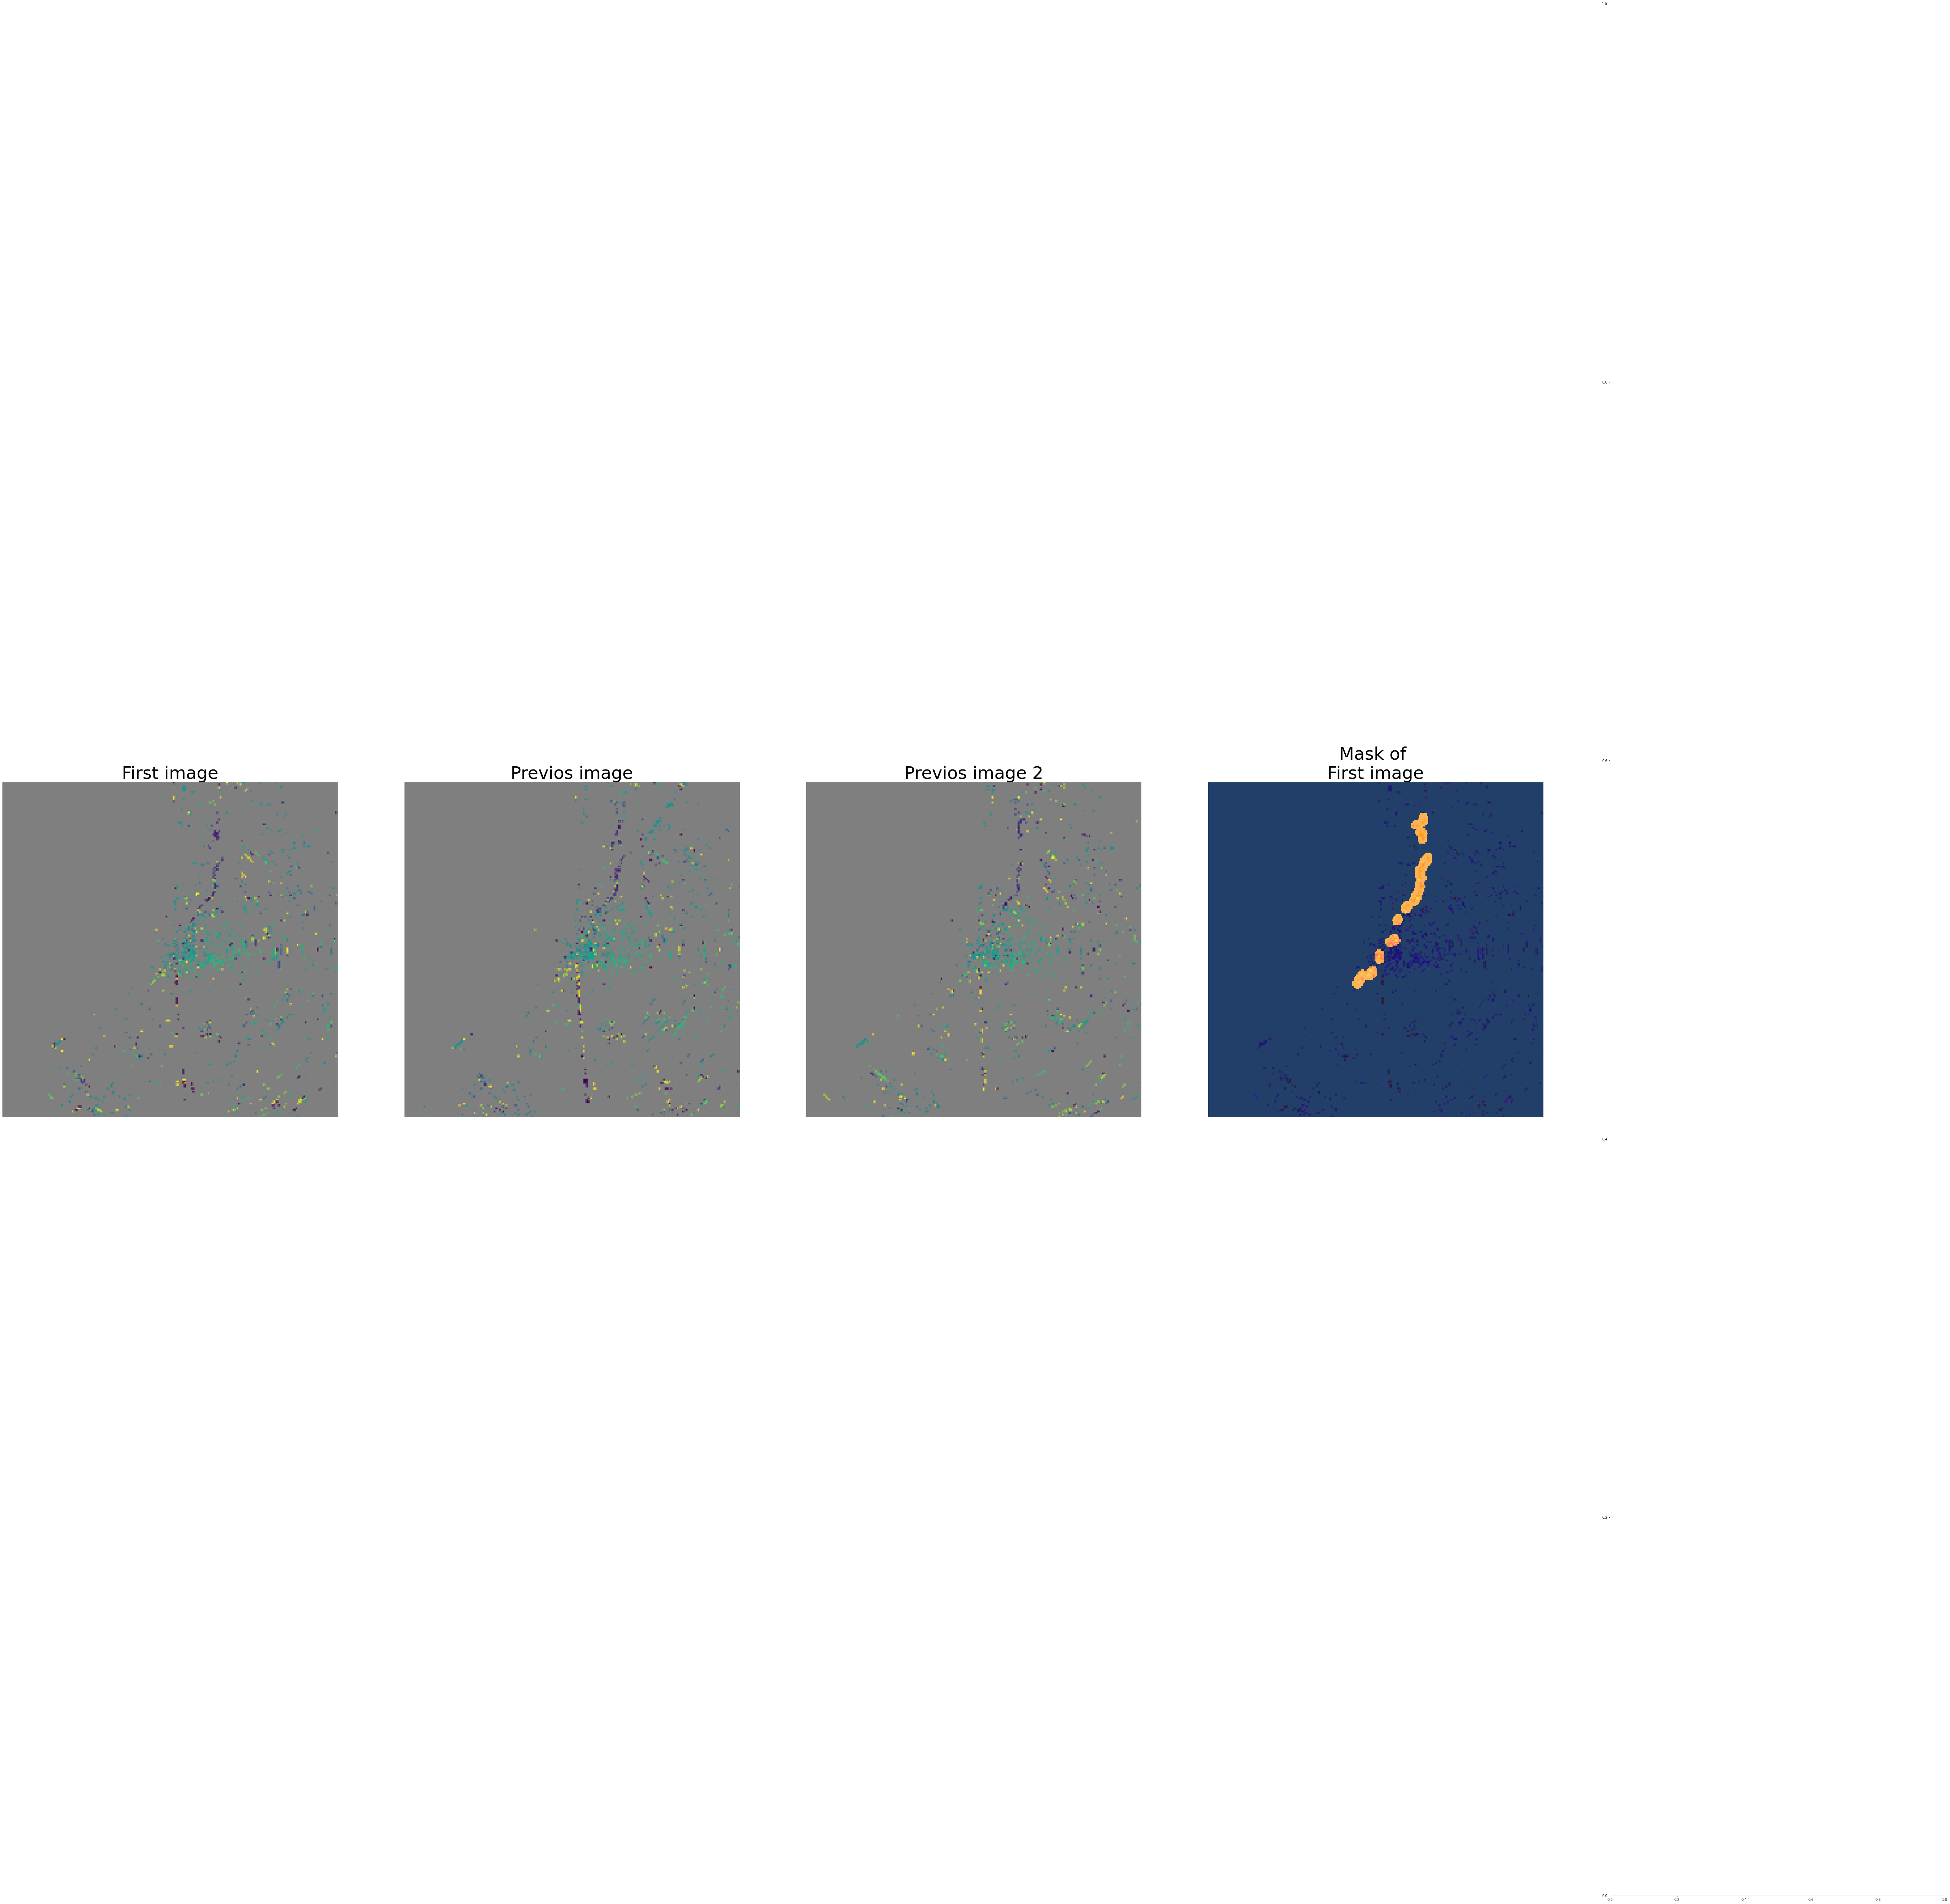

In [ ]:

img_2 = x[10]
img=img_2[:,:,0:3]
#print('img', img.shape)
#img_1=plt.imshow(img)

img_prev=img_2[:,:,3:6]
#print ('img_prev', img_prev.shape)

img_prev_2 = img_2[:,:,6:9]

msk = y[10]
#print('msk', msk.shape)
#msk1=plt.imshow(msk.squeeze())


# Make a True/False mask of pixels whose BGR values sum to more than zero
alpha = np.sum(msk, axis=-1) > 0
unique, counts = np.unique(alpha, return_counts=True)
alpha_2 = np.sum(msk) > 0


# Convert True/False to 0/255 and change type to "uint8" to match "na"
alpha = np.uint8(alpha * 255)


# Stack new alpha layer with existing image to go from BGR to BGRA, i.e. 3 channels to 4 channels
res = np.dstack((alpha, img))
#res1=plt.imshow(res)


#plt.savefig('/content/drive/My Drive/UNET/models/res1.png')

f, axarr = plt.subplots(1,5, figsize=(100,100))
axarr[0].imshow(img)
axarr[0].axis ('off')
axarr[0].set_title('First image', fontsize=50)

axarr[1].imshow(img_prev)
axarr[1].axis ('off')
axarr[1].set_title('Previos image', fontsize=50)

axarr[2].imshow(img_prev_2)
axarr[2].axis ('off')
axarr[2].set_title('Previos image 2', fontsize=50)

axarr[3].imshow(msk.squeeze())
axarr[3].axis ('off')
axarr[3].set_title('Mask of \nFirst image', fontsize=50)

axarr[4].imshow(res)
axarr[4].axis ('off')



IoU metric - I will not use it for now, need to change for not rectangle

**bold text**

In [ ]:
##I do want to understand each line here - Im not sure it will feet to my data
## It is for rectangle, there is an option to convert it to ploygons but in my case it's a few polygons in each frame so I'm not sure
## if I want to do it
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
# change to 12!
def unet(sz = (256, 256, 12)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
# kernel_regularizer=regularizers.l2(0.01)

  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64  
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  ##changed the metrics in the compile to accuracy
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou, 'accuracy'])
  
  return model

In [ ]:
def build_callbacks():
        filepath = 'my_best_model_3_prev_inc_noth.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
        #checkpoint_path = '/content/drive/My Drive/UNET/models/training_5/cp-{epoch:02d}.ckpt'
        checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        #callbacks = [PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}): 
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        raw_prev=[]
        while len(raw_prev)==0:
            #choose a random test image and preprocess
            path = np.random.choice(test_files)
            # What is this f'{path} - what does it do?
            raw = Image.open(f'{path}')
            raw = raw.crop(box)
            raw = np.array(raw.resize((256, 256)))/255.
            raw = raw[:,:,0:3]

            prev_image=create_early_image_3 (test_files,path,num_past, minuts)
            if len(prev_image)!=0:
            #print ('one less image to the batch') 
              raw_prev=np.concatenate((raw, prev_image),axis=2)
            


        ## add the original mask
        f_path= os.path.dirname(path) 
        num_f= str(int(os.path.basename(path).split('-')[0]))
        mask_file=[i for i in os.listdir(f_path) if os.path.isfile(os.path.join(f_path,i)) and 
         num_f == (os.path.basename(i).split('-')[0]) and '.png' in i]
        if len(mask_file)==0:
          mask=np.zeros((256,256))
        else:
          mask_file=str(mask_file)[2:-2]
          mask_path = os.path.join(f_path, mask_file) 
          mask = Image.open(mask_path).convert ('L')
          mask = mask.crop (box)
          #mask = np.array(mask.resize(sz))
          mask=np.array(mask.resize ((256,256)))
    
        
          ## changing the mask to be only 0/1
          mask[mask != 0 ] = 1
          
        
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw_prev, 0))
        pred=pred.squeeze()
        
        pred_0_1=np.copy(pred)
        pred_0_1[pred_0_1>=0.5] = 1
        pred_0_1[pred_0_1<0.5] = 0
        print ('pred_0_1 shape', pred_0_1.shape)
        unique, counts = np.unique(pred_0_1, return_counts=True)
        print('pred_0_1',dict(zip(unique, counts)))
        #quant=(np.quantile(pred, .20), np.quantile(pred, .50),np.quantile(pred, .75),np.quantile(pred, .95))
        # print('quantile pred', quant)
        #pred1=plt.imshow(pred)
        #plt.savefig('/content/drive/My Drive/UNET/models/pred1.png')
        



        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(raw)
        axarr[0].axis ('off')
        axarr[0].set_title('Radar image')
        axarr[1].imshow(mask)
        axarr[1].axis ('off')
        axarr[1].set_title('Mask Ground truth')
        #axarr[2].imshow(pred,cmap='gray')
        axarr[2].imshow(pred)
        axarr[2].axis ('off')
        axarr[2].set_title('Prediction')
        #axarr[2].imshow(pred_0_1)
        #axarr[2].axis ('off')
        #axarr[2].set_title('Predicted Mask')
        
 
        plt.show()
        

    
       

In [ ]:
model=tf.keras.models.load_model('/content/drive/My Drive/inbal_to_save/UNET/models/unet_9_1_prev',custom_objects={'mean_iou':mean_iou})
#model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
## Do not run this line If I choosed a model
model = unet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.load_weights('/content/colab_direcoty/models/unet-2-prev/my_best_model_2_prev_inc_noth.epoch17-loss0.01.hdf5')

Epoch 1/30
191/191 [==============================] - 2150s 11s/step - loss: 0.0955 - mean_iou: 4.6492e-06 - accuracy: 0.9864 - val_loss: 0.0610 - val_mean_iou: 0.0000e+00 - val_accuracy: 0.9929
i= 1 loss= 0.09513455109198099 val_loss= 0.06099487841129303 mean_iou= 4.6491573e-06 val_mean_iou= 0.0
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


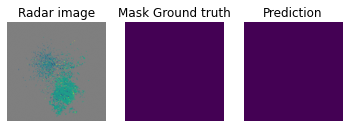

Epoch 2/30
191/191 [==============================] - 1950s 10s/step - loss: 0.0621 - mean_iou: 0.0000e+00 - accuracy: 0.9865 - val_loss: 0.0479 - val_mean_iou: 0.0000e+00 - val_accuracy: 0.9933
i= 2 loss= 0.06209045502628981 val_loss= 0.047862205654382706 mean_iou= 0.0 val_mean_iou= 0.0
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


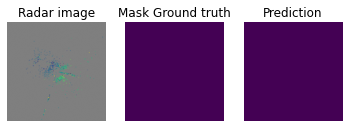

Epoch 3/30
191/191 [==============================] - 1982s 10s/step - loss: 0.0541 - mean_iou: 0.0000e+00 - accuracy: 0.9866 - val_loss: 0.0266 - val_mean_iou: 0.0000e+00 - val_accuracy: 0.9930
i= 3 loss= 0.05409257484474574 val_loss= 0.026604853570461273 mean_iou= 0.0 val_mean_iou= 0.0
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


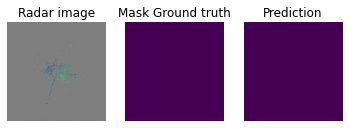

Epoch 4/30
170/191 [=========================>....] - ETA: 3:17 - loss: 0.0463 - mean_iou: 0.0000e+00 - accuracy: 0.9866

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


191/191 [==============================] - 2032s 11s/step - loss: 0.0465 - mean_iou: 0.0000e+00 - accuracy: 0.9864 - val_loss: 0.0245 - val_mean_iou: 7.3338e-06 - val_accuracy: 0.9928
i= 4 loss= 0.046485274788271684 val_loss= 0.02448083646595478 mean_iou= 0.0 val_mean_iou= 7.333786925300956e-06
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


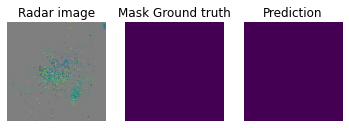

Epoch 5/30
191/191 [==============================] - 1979s 10s/step - loss: 0.0374 - mean_iou: 0.1064 - accuracy: 0.9875 - val_loss: 0.0275 - val_mean_iou: 0.2481 - val_accuracy: 0.9939
i= 5 loss= 0.03733709785279892 val_loss= 0.02748764120042324 mean_iou= 0.10636772 val_mean_iou= 0.24806638062000275
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


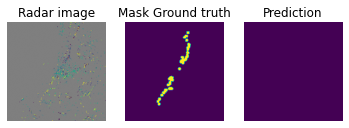

Epoch 6/30
191/191 [==============================] - 1953s 10s/step - loss: 0.0320 - mean_iou: 0.2818 - accuracy: 0.9893 - val_loss: 0.0473 - val_mean_iou: 0.3063 - val_accuracy: 0.9937
i= 6 loss= 0.03197036024459719 val_loss= 0.04732632637023926 mean_iou= 0.28182855 val_mean_iou= 0.30627521872520447
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


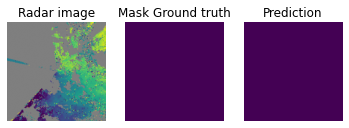

Epoch 7/30
191/191 [==============================] - 1954s 10s/step - loss: 0.0318 - mean_iou: 0.3116 - accuracy: 0.9893 - val_loss: 0.0190 - val_mean_iou: 0.1758 - val_accuracy: 0.9938
i= 7 loss= 0.031777509090960006 val_loss= 0.018965430557727814 mean_iou= 0.3115741 val_mean_iou= 0.17576882243156433
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


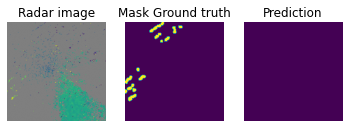

Epoch 8/30
191/191 [==============================] - 1948s 10s/step - loss: 0.0282 - mean_iou: 0.3546 - accuracy: 0.9899 - val_loss: 0.0221 - val_mean_iou: 0.2146 - val_accuracy: 0.9949
i= 8 loss= 0.028204634123020576 val_loss= 0.02213502675294876 mean_iou= 0.35458422 val_mean_iou= 0.21458348631858826
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


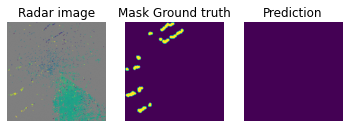

Epoch 9/30
191/191 [==============================] - 1956s 10s/step - loss: 0.0265 - mean_iou: 0.3846 - accuracy: 0.9903 - val_loss: 0.0506 - val_mean_iou: 0.3642 - val_accuracy: 0.9948
i= 9 loss= 0.026532049339521926 val_loss= 0.05058613419532776 mean_iou= 0.38461277 val_mean_iou= 0.3641940951347351
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


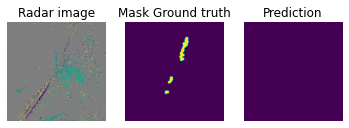

Epoch 10/30
191/191 [==============================] - 1975s 10s/step - loss: 0.0251 - mean_iou: 0.4191 - accuracy: 0.9908 - val_loss: 0.0214 - val_mean_iou: 0.3073 - val_accuracy: 0.9947
i= 10 loss= 0.025100442902684376 val_loss= 0.02142615057528019 mean_iou= 0.4191378 val_mean_iou= 0.3072841167449951
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


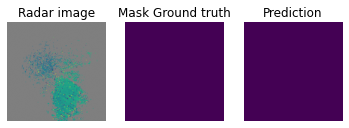

Epoch 11/30
191/191 [==============================] - 1979s 10s/step - loss: 0.0234 - mean_iou: 0.4327 - accuracy: 0.9911 - val_loss: 0.0245 - val_mean_iou: 0.1785 - val_accuracy: 0.9939
i= 11 loss= 0.023409904769830972 val_loss= 0.02450098656117916 mean_iou= 0.43269056 val_mean_iou= 0.17846566438674927
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


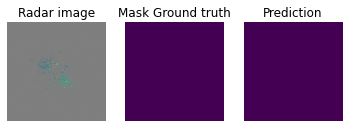

Epoch 12/30
191/191 [==============================] - 1963s 10s/step - loss: 0.0217 - mean_iou: 0.4608 - accuracy: 0.9918 - val_loss: 0.0184 - val_mean_iou: 0.3775 - val_accuracy: 0.9934
i= 12 loss= 0.021717367742748298 val_loss= 0.018446119502186775 mean_iou= 0.46080995 val_mean_iou= 0.37751227617263794
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


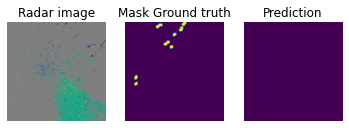

Epoch 13/30
191/191 [==============================] - 1925s 10s/step - loss: 0.0218 - mean_iou: 0.4734 - accuracy: 0.9916 - val_loss: 0.0222 - val_mean_iou: 0.4049 - val_accuracy: 0.9950
i= 13 loss= 0.021789739194054306 val_loss= 0.02217181958258152 mean_iou= 0.4734077 val_mean_iou= 0.4049193561077118
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


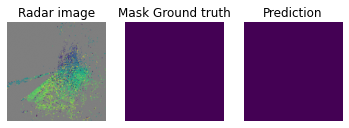

Epoch 14/30
191/191 [==============================] - 1925s 10s/step - loss: 0.0205 - mean_iou: 0.4857 - accuracy: 0.9919 - val_loss: 0.0199 - val_mean_iou: 0.3036 - val_accuracy: 0.9947
i= 14 loss= 0.02050865756619378 val_loss= 0.01989826001226902 mean_iou= 0.48565942 val_mean_iou= 0.3035757839679718
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


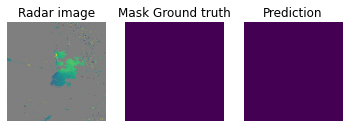

Epoch 15/30
191/191 [==============================] - 1940s 10s/step - loss: 0.0202 - mean_iou: 0.5002 - accuracy: 0.9920 - val_loss: 0.0263 - val_mean_iou: 0.3809 - val_accuracy: 0.9935
i= 15 loss= 0.020195502767515715 val_loss= 0.0262861717492342 mean_iou= 0.5001656 val_mean_iou= 0.38088753819465637
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 64835, 1.0: 701}


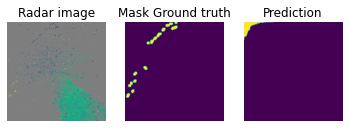

Epoch 16/30
191/191 [==============================] - 1927s 10s/step - loss: 0.0190 - mean_iou: 0.5047 - accuracy: 0.9925 - val_loss: 0.0206 - val_mean_iou: 0.3918 - val_accuracy: 0.9950
i= 16 loss= 0.01897223101661819 val_loss= 0.020579630509018898 mean_iou= 0.5046857 val_mean_iou= 0.3918446898460388
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65517, 1.0: 19}


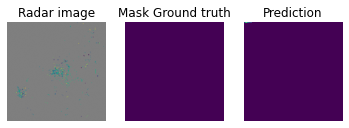

Epoch 17/30
191/191 [==============================] - 1948s 10s/step - loss: 0.0188 - mean_iou: 0.5197 - accuracy: 0.9925 - val_loss: 0.0322 - val_mean_iou: 0.4468 - val_accuracy: 0.9952
i= 17 loss= 0.018820889043977124 val_loss= 0.032221827656030655 mean_iou= 0.51965016 val_mean_iou= 0.44683125615119934
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


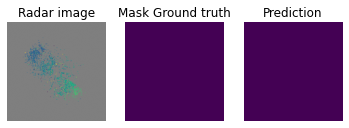

Epoch 18/30
191/191 [==============================] - 1927s 10s/step - loss: 0.0184 - mean_iou: 0.5283 - accuracy: 0.9926 - val_loss: 0.0166 - val_mean_iou: 0.4534 - val_accuracy: 0.9953
i= 18 loss= 0.018379978034062338 val_loss= 0.016605570912361145 mean_iou= 0.52825475 val_mean_iou= 0.4533957839012146
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


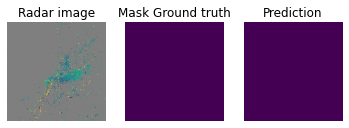

Epoch 19/30
191/191 [==============================] - 1945s 10s/step - loss: 0.0175 - mean_iou: 0.5405 - accuracy: 0.9929 - val_loss: 0.0213 - val_mean_iou: 0.4404 - val_accuracy: 0.9954
i= 19 loss= 0.017452761357606844 val_loss= 0.021304059773683548 mean_iou= 0.5405458 val_mean_iou= 0.44042128324508667
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


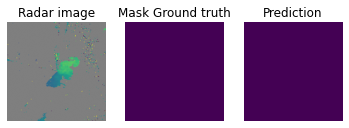

Epoch 20/30
191/191 [==============================] - 1983s 10s/step - loss: 0.0179 - mean_iou: 0.5443 - accuracy: 0.9927 - val_loss: 0.0252 - val_mean_iou: 0.4253 - val_accuracy: 0.9939
i= 20 loss= 0.017916236211006915 val_loss= 0.025249263271689415 mean_iou= 0.5443185 val_mean_iou= 0.4252913296222687
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65419, 1.0: 117}


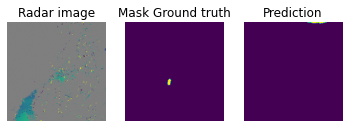

Epoch 21/30
191/191 [==============================] - 1933s 10s/step - loss: 0.0163 - mean_iou: 0.5560 - accuracy: 0.9933 - val_loss: 0.0436 - val_mean_iou: 0.4273 - val_accuracy: 0.9952
i= 21 loss= 0.016360038588746784 val_loss= 0.04360244423151016 mean_iou= 0.55596167 val_mean_iou= 0.4273146688938141
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


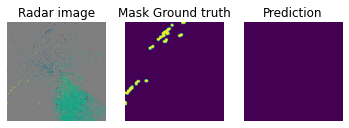

Epoch 22/30
191/191 [==============================] - 1937s 10s/step - loss: 0.0161 - mean_iou: 0.5662 - accuracy: 0.9934 - val_loss: 0.0278 - val_mean_iou: 0.4299 - val_accuracy: 0.9943
i= 22 loss= 0.016116088196374893 val_loss= 0.027753835543990135 mean_iou= 0.566225 val_mean_iou= 0.4299236536026001
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65469, 1.0: 67}


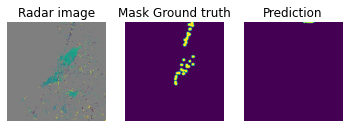

Epoch 23/30
191/191 [==============================] - 1963s 10s/step - loss: 0.0163 - mean_iou: 0.5705 - accuracy: 0.9933 - val_loss: 0.0187 - val_mean_iou: 0.4323 - val_accuracy: 0.9951
i= 23 loss= 0.016354468590957925 val_loss= 0.018683893606066704 mean_iou= 0.570494 val_mean_iou= 0.4323148727416992
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


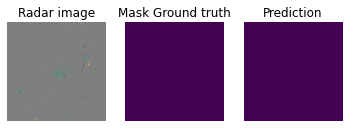

Epoch 24/30
191/191 [==============================] - 1964s 10s/step - loss: 0.0159 - mean_iou: 0.5860 - accuracy: 0.9934 - val_loss: 0.0188 - val_mean_iou: 0.4409 - val_accuracy: 0.9951
i= 24 loss= 0.01585000896085179 val_loss= 0.018793625757098198 mean_iou= 0.58596003 val_mean_iou= 0.44090089201927185
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65086, 1.0: 450}


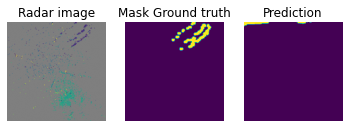

Epoch 25/30
191/191 [==============================] - 1938s 10s/step - loss: 0.0157 - mean_iou: 0.5874 - accuracy: 0.9935 - val_loss: 0.0143 - val_mean_iou: 0.4467 - val_accuracy: 0.9950
i= 25 loss= 0.01570944729004396 val_loss= 0.014315572567284107 mean_iou= 0.5873862 val_mean_iou= 0.44670557975769043
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


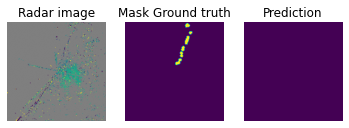

Epoch 26/30
191/191 [==============================] - 1945s 10s/step - loss: 0.0153 - mean_iou: 0.5973 - accuracy: 0.9937 - val_loss: 0.0092 - val_mean_iou: 0.4479 - val_accuracy: 0.9948
i= 26 loss= 0.015291517261696173 val_loss= 0.009226405061781406 mean_iou= 0.5972828 val_mean_iou= 0.4478828012943268
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


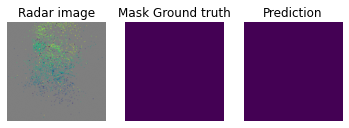

Epoch 27/30
191/191 [==============================] - 1962s 10s/step - loss: 0.0148 - mean_iou: 0.6021 - accuracy: 0.9939 - val_loss: 0.0133 - val_mean_iou: 0.4352 - val_accuracy: 0.9948
i= 27 loss= 0.014750901902826559 val_loss= 0.013257765211164951 mean_iou= 0.6020514 val_mean_iou= 0.43520495295524597
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


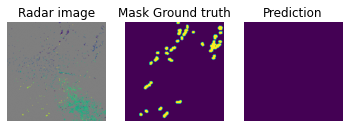

Epoch 28/30
191/191 [==============================] - 1965s 10s/step - loss: 0.0152 - mean_iou: 0.6111 - accuracy: 0.9937 - val_loss: 0.0129 - val_mean_iou: 0.4659 - val_accuracy: 0.9947
i= 28 loss= 0.015218202114849639 val_loss= 0.012870870530605316 mean_iou= 0.6110979 val_mean_iou= 0.4659045934677124
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


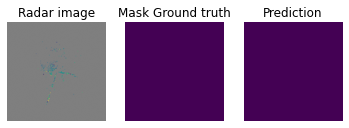

Epoch 29/30
191/191 [==============================] - 1973s 10s/step - loss: 0.0144 - mean_iou: 0.6132 - accuracy: 0.9940 - val_loss: 0.0094 - val_mean_iou: 0.4231 - val_accuracy: 0.9943
i= 29 loss= 0.01440990458983504 val_loss= 0.009435353800654411 mean_iou= 0.61318606 val_mean_iou= 0.42313557863235474
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 64290, 1.0: 1246}


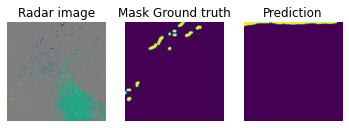

Epoch 30/30
191/191 [==============================] - 6006s 31s/step - loss: 0.0143 - mean_iou: 0.6181 - accuracy: 0.9940 - val_loss: 0.0138 - val_mean_iou: 0.4146 - val_accuracy: 0.9944
i= 30 loss= 0.014264731510684997 val_loss= 0.0138419009745121 mean_iou= 0.61810166 val_mean_iou= 0.4145943224430084
pred_0_1 shape (256, 256)
pred_0_1 {0.0: 65536}


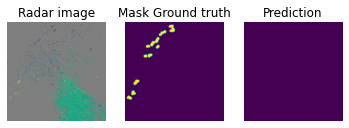

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
history=model.fit_generator(train_generator,               
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                     callbacks = build_callbacks(),verbose = 1)

#model.save('/content/drive/My Drive/UNET/models/unet_9_4_prev')

#with open('/content/drive/My Drive/UNET/models/trainHistoryDict_9_4_prev', 'wb') as file_pi:
        #pickle.dump(history.history, file_pi)

In [ ]:
model.save('unet_12_3_prev_inc_noth')

with open('trainHistoryDict_12_unet_3_prev_inc_noth', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_iou', 'val_accuracy', 'loss', 'mean_iou', 'accuracy'])

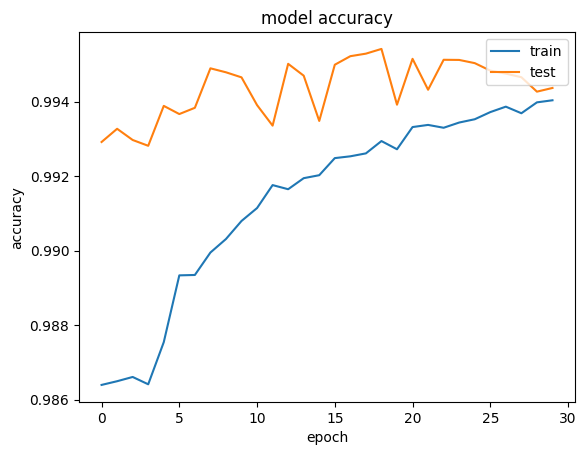

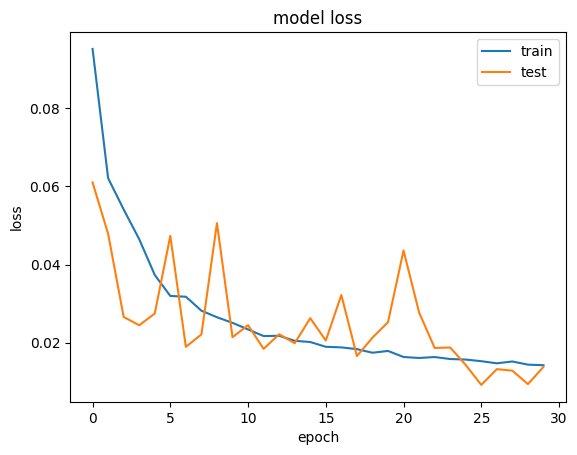

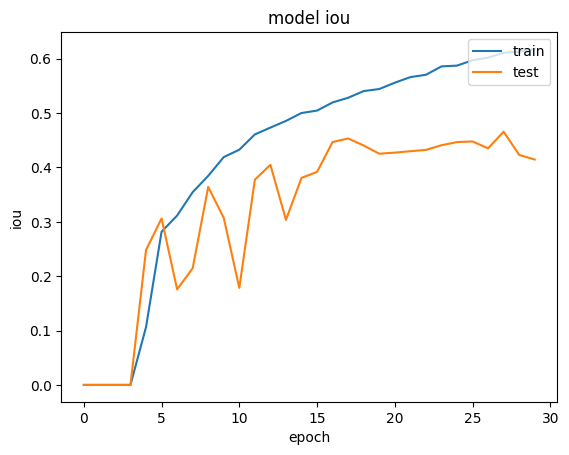

In [ ]:
## plot the figurs

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.style.use('default')
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [ ]:
history=pickle.load(open('/content/colab_direcoty/models/unet-3-prev/trainHistoryDict_12_unet_3_prev_inc_noth', "rb"))
history['accuracy'][17:19]

[0.9926127, 0.9929438]

In [ ]:
model = unet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
## by the graphes choosing the best model: after 18 epochos

model.load_weights('/content/colab_direcoty/models/unet-3-prev/my_best_model_3_prev_inc_noth.epoch18-loss0.02.hdf5')



In [ ]:
## finding the first shape
#test_steps = len(list_winter) //batch_size
print ('length test files', len(test_files))
test_steps = len(test_files) //batch_size

print (test_steps)


x_1=batch_size *test_steps

print (x_1)

length test files 1370
42
1344


**Creating array of the test files for predict not from the generator**


In [ ]:

"""
x_test=np.zeros((x_1,256,256,9))
y_test=np.zeros((x_1,256,256,1))

right = 0
left = 0

for x_i, y_i in test_generator:
  
  left=right
  right += x_i.shape[0]
  if right>=x_1:
    break
  #print ('left', left)
  

  x_test[left:right,:,:,:] = x_i
  
    
  y_test[left:right,:,:,:] = y_i


x_test = x_test[:left,:,:,:]
y_test = y_test[:left,:,:,:]



print ('x_test', x_test.shape)
print ('y_test', y_test.shape)

"""
x_test=np.zeros((x_1,256,256,12))
y_test=np.zeros((x_1,256,256,1))

right = 0
left = 0

for x_i, y_i in test_generator:
  
  left=right
  right += x_i.shape[0]
  if right>=x_1:
    break
  #print ('left', left)
  

  x_test[left:right,:,:,:] = x_i
  
    
  y_test[left:right,:,:,:] = y_i


x_test = x_test[:left,:,:,:]
y_test = y_test[:left,:,:,:]



print ('x_test', x_test.shape)
print ('y_test', y_test.shape)







x_test (1314, 256, 256, 12)
y_test (1314, 256, 256, 1)


msk (256, 256, 1)


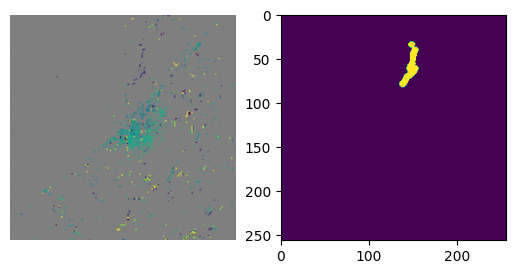

In [ ]:
img = x_test[10]



msk = y_test[10]
print('msk', msk.shape)


f, axarr = plt.subplots(1,2)
axarr[0].imshow(img)
axarr[0].axis ('off')
axarr[1].imshow(msk.squeeze())

In [ ]:
predict=model.predict(x_test)
print (predict.shape)







(1314, 256, 256, 1)


In [ ]:
print (predict[:1])

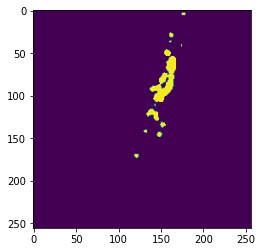

In [ ]:
y_pred_0_1=np.copy(predict)
y_pred_0_1[y_pred_0_1>=0.5] = 1
y_pred_0_1[y_pred_0_1<0.5] = 0

predict_10=y_pred_0_1[10]

plt.imshow(predict_10.squeeze())

In [ ]:
print(y_pred_0_1.shape)

(412, 256, 256, 1)


In [ ]:
#path="/content/drive/My Drive/inbal_to_save/UNET/data/prev"


#np.save(os.path.join(path, 'y_pred'),y_pred_0_1)
#np.save(os.path.join(path,"y_test"), y_test)
#np.save(os.path.join(path,"x_test"), x_test)


## for saving in the colab enviroment
np.save('y_pred_3_prev',y_pred_0_1)
np.save("y_test_3_prev", y_test)
np.save("x_test_3_prev", x_test)

In [ ]:
#x_test = np.load('x_test_3_prev.npy')
y_test = np.load('y_test_3_prev.npy')
y_pred = np.load ('y_pred_3_prev.npy')

In [ ]:
from google.colab import files

#result.to_csv('example_file.csv')
# !cp x_test.npy "/content/drive/My Drive/inbal_to_save/UNET/"
files.download('x_test_3_prev.npy')
files.download('y_pred_3_prev.npy')
files.download('y_test_3_prev.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Area under the ROC curve: 0.7920360632205117


"\n# generate a no skill prediction (majority class)\nns_probs = [0 for _ in range(len(y_test))]\n\n# keep probabilities for the positive outcome only\nlr_probs = predict[:, 1]\nns_auc = roc_auc_score(y_test, ns_probs)\nlr_auc = roc_auc_score(y_test, lr_probs)\n\ny_test = y_test.astype('int')\n\nprint(type_of_target(y_test))\nprint (type_of_target(predict))\n\n#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predict)\n#fpr, tpr = roc_curve(y_test,y_pred)\n"

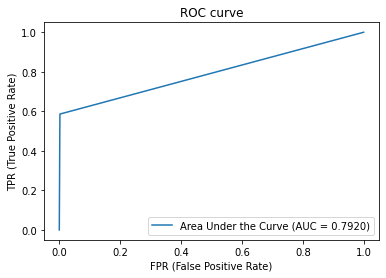

In [ ]:
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_test=y_test.squeeze()
predict=predict.squeeze()
predictions = np.where(predict>0.5, 1, 0)


y_scores = predictions.reshape(predictions.shape[0]*predictions.shape[1]*predictions.shape[2], 1)
#print(y_scores.shape)

y_true = y_test.reshape(y_test.shape[0]*y_test.shape[1]*y_test.shape[2], 1)
#print(y_true.shape)


y_scores = np.where(y_scores>0.5, 1, 0)
y_true   = np.where(y_true>0.5, 1, 0)

fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
print ("\nArea under the ROC curve: " +str(AUC_ROC))

roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
#plt.imshow()

"""
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
lr_probs = predict[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

y_test = y_test.astype('int')

print(type_of_target(y_test))
print (type_of_target(predict))

#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predict)
#fpr, tpr = roc_curve(y_test,y_pred)
"""

In [ ]:
from sklearn.metrics import f1_score
threshold_confusion = 0.5
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0


F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))



F1 score (F-measure): 0.6224635990463205



Area under Precision-Recall curve: 0.5972651440077382


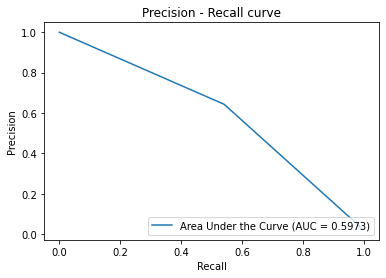

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0] 
recall = np.fliplr([recall])[0]
AUC_prec_rec = np.trapz(precision,recall)
print ("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")

In [ ]:
print (y_test.shape)
print ( y_pred.shape)

unique_full, counts_full = np.unique(y_test, return_counts=True)
print('y_test',dict(zip(unique_full, counts_full)))

unique_full, counts_full = np.unique(predict, return_counts=True)
print('y_pres',dict(zip(unique_full, counts_full)))




(416, 256, 256, 1)
(416, 256, 256, 1)
y_test {0: 26686326, 1: 576650}
y_pres 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
y_vec_1=y_all.flatten()
y_pred_1=y_pred.flatten()

print(len(y_vec_1))
print (len(y_pred_1))

27262976
27262976


In [ ]:
unique_full, counts_full = np.unique(y_vec_1, return_counts=True)
print('y_vec',dict(zip(unique_full, counts_full)))

unique_full, counts_full = np.unique(y_all, return_counts=True)
print('y_all',dict(zip(unique_full, counts_full)))


y_vec {0: 26651474, 1: 611502}
y_all {0: 26651474, 1: 611502}


In [ ]:
from google.protobuf.descriptor import EnumValueDescriptor
### to try also to do this part - predicting group of images and see the resuls

from sklearn.metrics import classification_report



matrix= confusion_matrix (y_vec_1,y_pred_1,labels=[1,0])
print('Confusion matrix : \n',matrix)

tp, fn, fp, tn = confusion_matrix(y_vec_1,y_pred_1,labels=[1,0]).reshape(-1)
print("tp", tp, "fn", fn, "fp", fp, "tn", tn)



Confusion matrix : 
 [[  325655   285847]
 [  170070 26481404]]
Outcome values : 
 325655 285847 170070 26481404


In [ ]:
print("tp", tp, "fn", fn, "fp", fp, "tn", tn)

print ("tp/AP", tp/(tp+fn))
print ('tn/AN', tn/(tn + fp))
print ('precition', tp /(tp+ fp))

tp 325655 fn 285847 fp 170070 tn 26481404
tp/AP 0.5325493620625934
tn/AN 0.9936187394363254
precition 0.6569267234858036


In [ ]:
matrix = classification_report(y_vec_1,y_pred_1,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.66      0.53      0.59    611502
           0       0.99      0.99      0.99  26651474

    accuracy                           0.98  27262976
   macro avg       0.82      0.76      0.79  27262976
weighted avg       0.98      0.98      0.98  27262976



I don't know if I can do this graphs in this project - to read

In [ ]:
# predict probabilities
lr_probs=model.predict_proba(x_all)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]


##### for recall/precition graph

yhat = model.predict(x_all)
lr_precision, lr_recall, _ = precision_recall_curve(y_all, lr_probs)
lr_f1, lr_auc = f1_score(y_all, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_all[y_all==1]) / len(y_all)
#plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
#plt.ylim([0.5,0.7])
#plt.xlim([0.01,1])
# show the plot
plt.show()

AttributeError: ignored

Predecting on a batch of Images from model 1
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


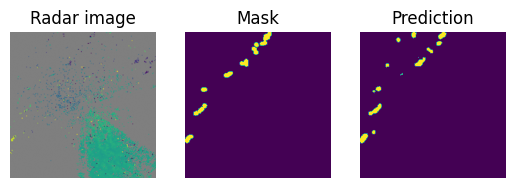

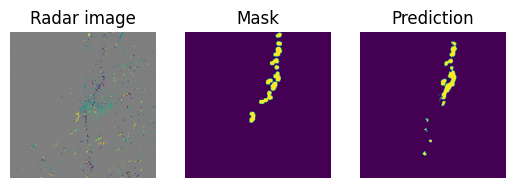

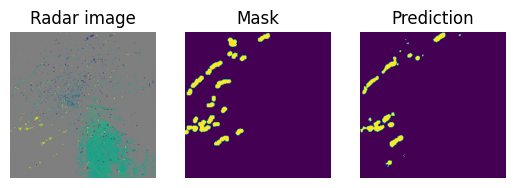

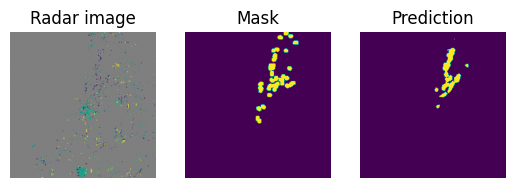

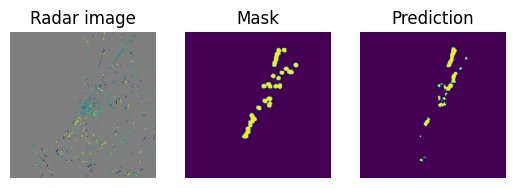

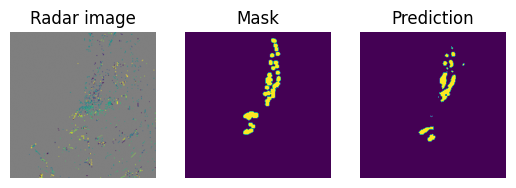

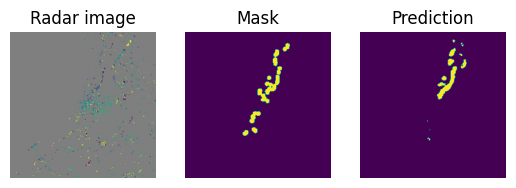

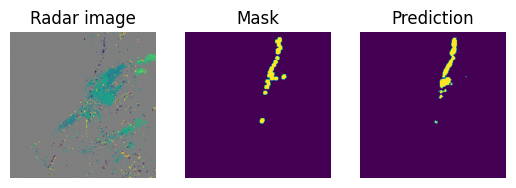

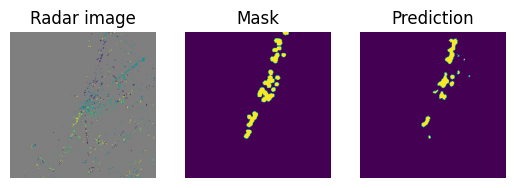

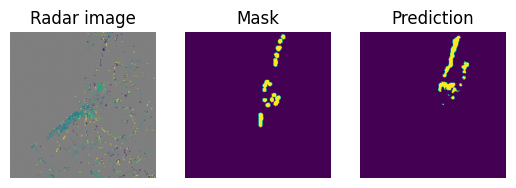

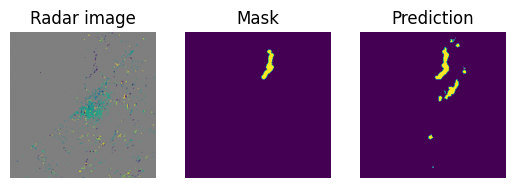

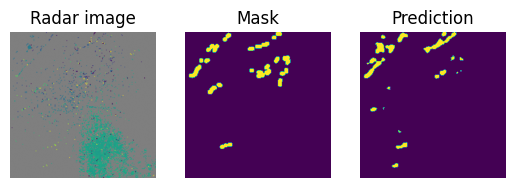

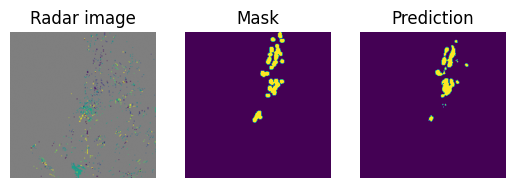

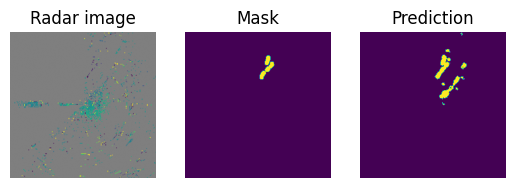

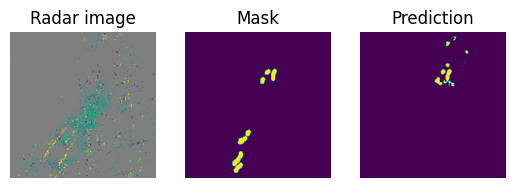

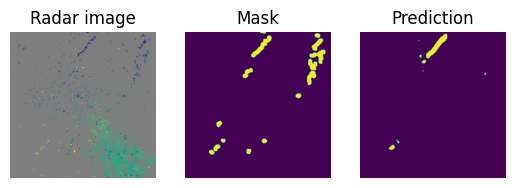

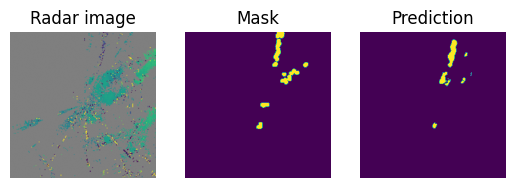

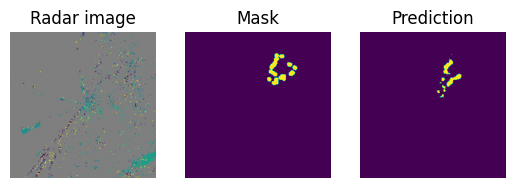

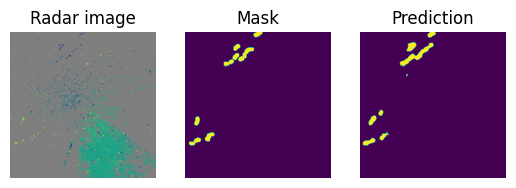

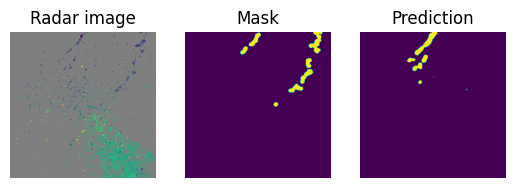

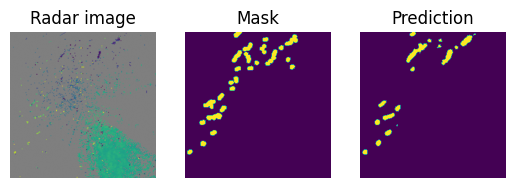

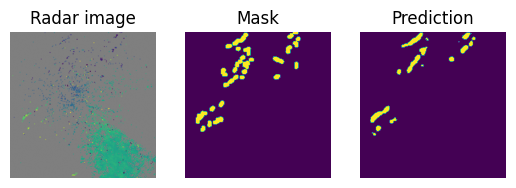

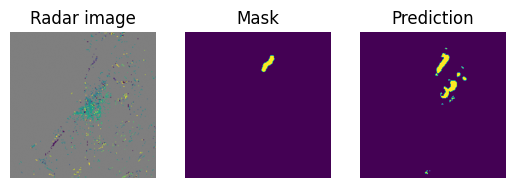

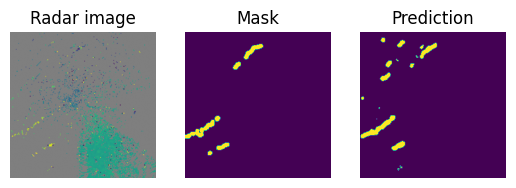

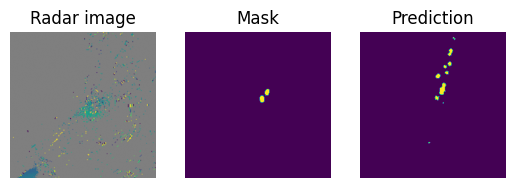

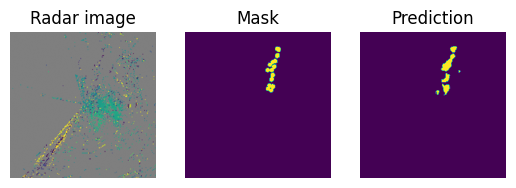

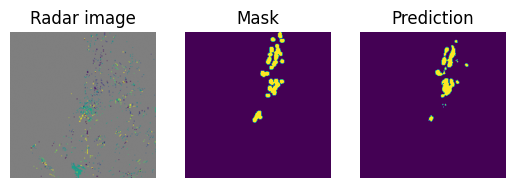

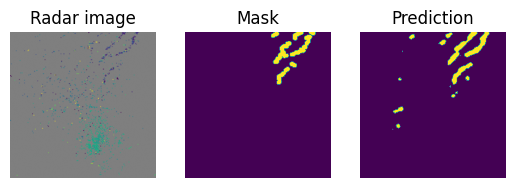

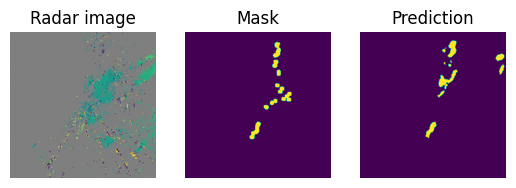

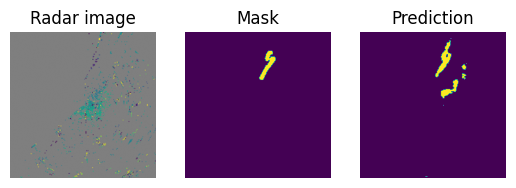

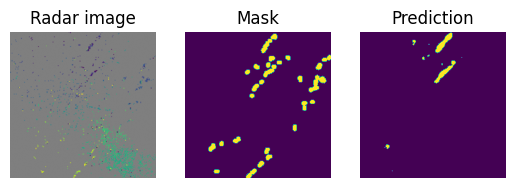

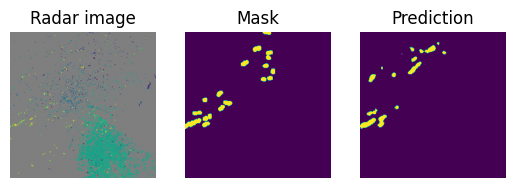

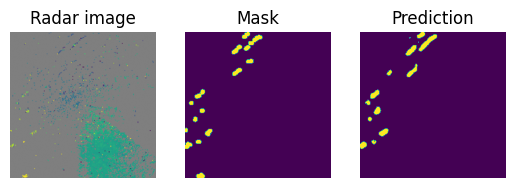

In [ ]:


for i,img in enumerate(x_all):
  if i>32:
    break
  f, axarr = plt.subplots(1,3)
  axarr[0].imshow(img)
  axarr[0].axis ('off')
  axarr[0].set_title('Radar image')
  axarr[1].imshow(y_all[i].squeeze())
  axarr[1].axis ('off')
  axarr[1].set_title('Mask')
  axarr[2].imshow(y_pred[i].squeeze())
  axarr[2].axis ('off')
  axarr[2].set_title('Prediction')
         


In [ ]:
## tamir talk




for x,y in test_generator
x_all = np.concatenate(x_all,x)

y_all = np.concatenate(y_all_y)

model.predict(x_all)
From tamir to Everyone 02:39 PM
dropout
loss regularization


https://cloud.google.com/apigee/docs/hybrid/v1.1/precog-gcpaccount

